In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import sys

root = os.path.abspath("..")
sys.path.append(root)

from config import Config
from common.constants import MODALITY_SET
from plant_net_meta import PlantNetImage
from plant_clef_meta import PlantClefImage

# Loading Config

In [2]:
CONFIG = Config(os.path.join(root, "config.json"))

# Loading Pl@ntNet meta

In [3]:
plant_net_meta = PlantNetImage.load(CONFIG)

# Loading & Caching PlantCLEF2015 meta

In [4]:
plant_clef_meta = PlantClefImage.load(CONFIG, from_cache=True)
PlantClefImage.save(CONFIG, plant_clef_meta, pretty=True)

# Counting Pl@ntNet Organs

In [5]:
def calc_plant_net_organs(meta):
    organs = {}

    for value in meta.values():
        organ = value.organ
        organs[organ] = (organs[organ] + 1) if organ in organs else 1
    
    return organs

print("PlantNet organs:")
plant_net_organs = calc_plant_net_organs(plant_net_meta)
plant_net_organs

PlantNet organs:


{'leaf': 110784,
 'flower': 176531,
 'habit': 4445,
 'fruit': 11277,
 'bark': 2076,
 'other': 993,
 'branch': 37,
 'scan': 2,
 'none': 1}

# Counting PlantCLEF2015 Organs

In [6]:
def calc_plant_clef_organs(meta):
    organs = {}

    for img in meta:
        organ = img.content
        organs[organ] = (organs[organ] + 1) if organ in organs else 1
    
    return organs

print("PlantCLEF organs:")
plant_clef_organs = calc_plant_clef_organs(plant_clef_meta)
plant_clef_organs

PlantCLEF organs:


{'Flower': 36552,
 'Entire': 22348,
 'LeafScan': 12826,
 'Fruit': 9143,
 'Leaf': 16057,
 'Stem': 6060,
 'Branch': 10218}

##### Helper to Save Plots at _images_ Directory

In [7]:
def save_plot(name):
    if not os.path.exists("images"):
        os.mkdir("images")
    plt.savefig(os.path.join("images", name))

In [ ]:
FONT_LABEL = {"weight": "semibold"}
FONT_TITLE = {"weight": "bold", "size": 14}

# Plotting Pl@ntNet and PlantCLEF2015 Organ Counts

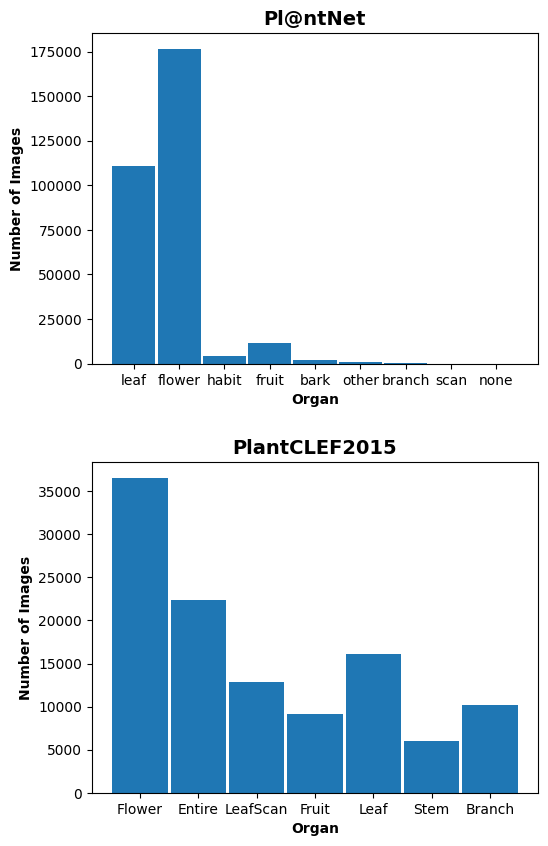

In [8]:
save = False  # <<<<<<< SET TO TRUE TO SAVE PLOT


fig, ax = plt.subplots(2)
fig.set_size_inches((6, 9))
fig.tight_layout(h_pad=5, pad=4)

def plot_axis(ax, organs, title):
    ax.bar(organs.keys(), organs.values(), width=0.95)
    ax.set_xlabel("Organ", fontdict=FONT_LABEL)
    ax.set_ylabel("Number of Images", fontdict=FONT_LABEL)
    ax.set_title(title, fontdict=FONT_TITLE)

plot_axis(ax[0], plant_net_organs, "Pl@ntNet")
plot_axis(ax[1], plant_clef_organs, "PlantCLEF2015")

if save:
    save_plot("dataset_organs.pdf")

# Filtering PlantCLEF2015 Organs

In [9]:
RELEVANT_ORGANS = MODALITY_SET

filtered_plant_clef_meta = [img for img in plant_clef_meta if img.content in RELEVANT_ORGANS]

# Output Descriptive Statistics of the Dataset and Plot Class Distribution

PlantCLEF stats:
Min: 1
Max: 475
Mean: 67.87987987987988
Std: 56.76742134104118
Sum: 67812
Number of classes: 999


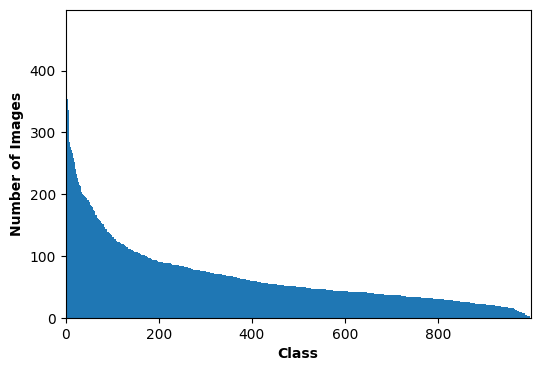

In [10]:
save = False  # <<<<<<< SET TO TRUE TO SAVE PLOT


def get_plant_clef_class_distribution(meta):
    classes = {}

    for img in meta:
        cls = img.class_id
        classes[cls] = (classes[cls] + 1) if cls in classes else 1
    
    return np.array(sorted(classes.items(), key=lambda i: i[1], reverse=True))

plant_clef_class_dist = get_plant_clef_class_distribution(filtered_plant_clef_meta)
plant_clef_class_map = {c: i for i, c in enumerate(plant_clef_class_dist[:, 0])}
plant_clef_class_dist = plant_clef_class_dist[:, 1]

indices = range(len(plant_clef_class_dist))

print("PlantCLEF stats:")
print(f"Min: {np.min(plant_clef_class_dist)}")
print(f"Max: {np.max(plant_clef_class_dist)}")
print(f"Mean: {np.mean(plant_clef_class_dist)}")
print(f"Std: {np.std(plant_clef_class_dist)}")
print(f"Sum: {len(filtered_plant_clef_meta)}")
print(f"Number of classes: {len(indices)}")

plt.figure(figsize=(6, 4))
plt.tight_layout(pad=4)
plt.bar(indices, plant_clef_class_dist, width=1)
plt.xlabel("Class", fontdict=FONT_LABEL)
plt.ylabel("Number of Images", fontdict=FONT_LABEL)
plt.gca().set_xlim([0, len(plant_clef_class_dist)]);

if save:
    save_plot("class_distribution.pdf")

# Create Dataframe with the Dataset observations (plant specimens) and Corresponding Organ Counts

In [11]:
def get_observations_dataframe(meta, organs):
    df = pd.DataFrame(columns=["ObservationId", *organs, "ClassId"])

    for img in meta:
        idx = df["ObservationId"] == img.observation_id
        if idx.any():
            assert img.class_id == df[idx]["ClassId"].iloc[0]
            df.loc[idx, img.content] += 1
        else:
            df.loc[len(df)] = {
                "ObservationId": img.observation_id,
                "ClassId": img.class_id,
                **{o: 0 for o in organs},
                img.content: 1,
            }
    return df

plant_clef_observations = get_observations_dataframe(filtered_plant_clef_meta, RELEVANT_ORGANS)
plant_clef_observations.head()

,ObservationId,Leaf,Fruit,Flower,Stem,ClassId
0,7354,1,0,3,2,2140
1,5554,0,0,3,0,3773
2,9663,0,0,4,0,6521
3,18122,1,1,0,1,4487
4,14317,3,0,0,4,3297


# Output Descriptive Statistics for Observations

In [12]:
plant_clef_observations.drop(columns=["ObservationId", "ClassId"]).describe()

,Leaf,Fruit,Flower,Stem
count,28465.000000,28465.000000,28465.000000,28465.000000
mean,0.564096,0.321201,1.284103,0.212893
std,1.681469,1.115553,1.736158,0.838654
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,2.000000,0.000000
max,49.000000,32.000000,67.000000,28.000000


# Plot Organ Distribution among Observations

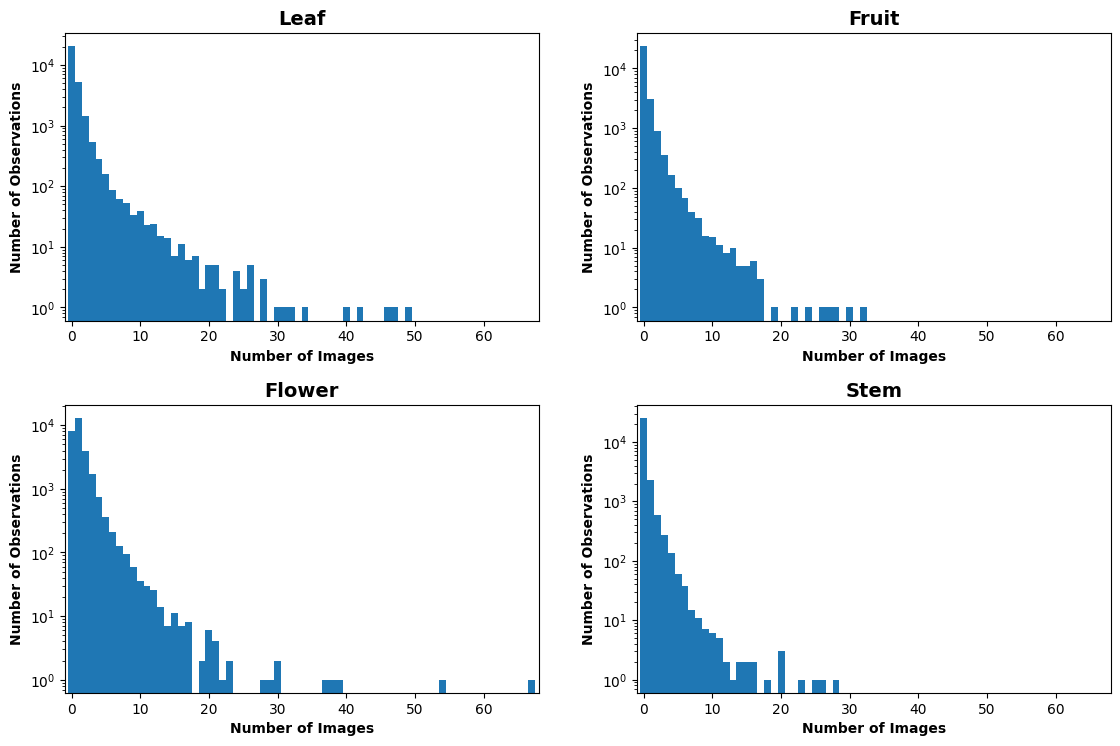

In [13]:
save = False  # <<<<<<< SET TO TRUE TO SAVE PLOT


def get_organ_distribution(df_observations: pd.DataFrame, organ):
    series = df_observations[organ]
    range_of_counts = range(series.max() + 1)

    return [(series == count).sum() for count in range_of_counts]

def plot_organ_distributions():
    fig, ax = plt.subplots(2, 2)

    fig.set_size_inches((12, 8))
    fig.tight_layout(pad=4)

    ax = np.reshape(ax, -1)

    organs = list(RELEVANT_ORGANS)
    organ_dists = [get_organ_distribution(plant_clef_observations, organ) for organ in RELEVANT_ORGANS]

    max_length = max(map(lambda d: len(d), organ_dists))

    for index in range(len(organ_dists)):
        dist = organ_dists[index]
        indices = range(len(dist))

        ax[index].set_yscale("log")
        ax[index].set_xlim([-1, max_length])
        ax[index].bar(indices, dist, width=1)
        ax[index].set_title(organs[index], fontdict=FONT_TITLE)
        ax[index].set_xlabel("Number of Images", fontdict=FONT_LABEL)
        ax[index].set_ylabel("Number of Observations", fontdict=FONT_LABEL)

plot_organ_distributions()

if save:
    save_plot("organ_distribution.pdf")

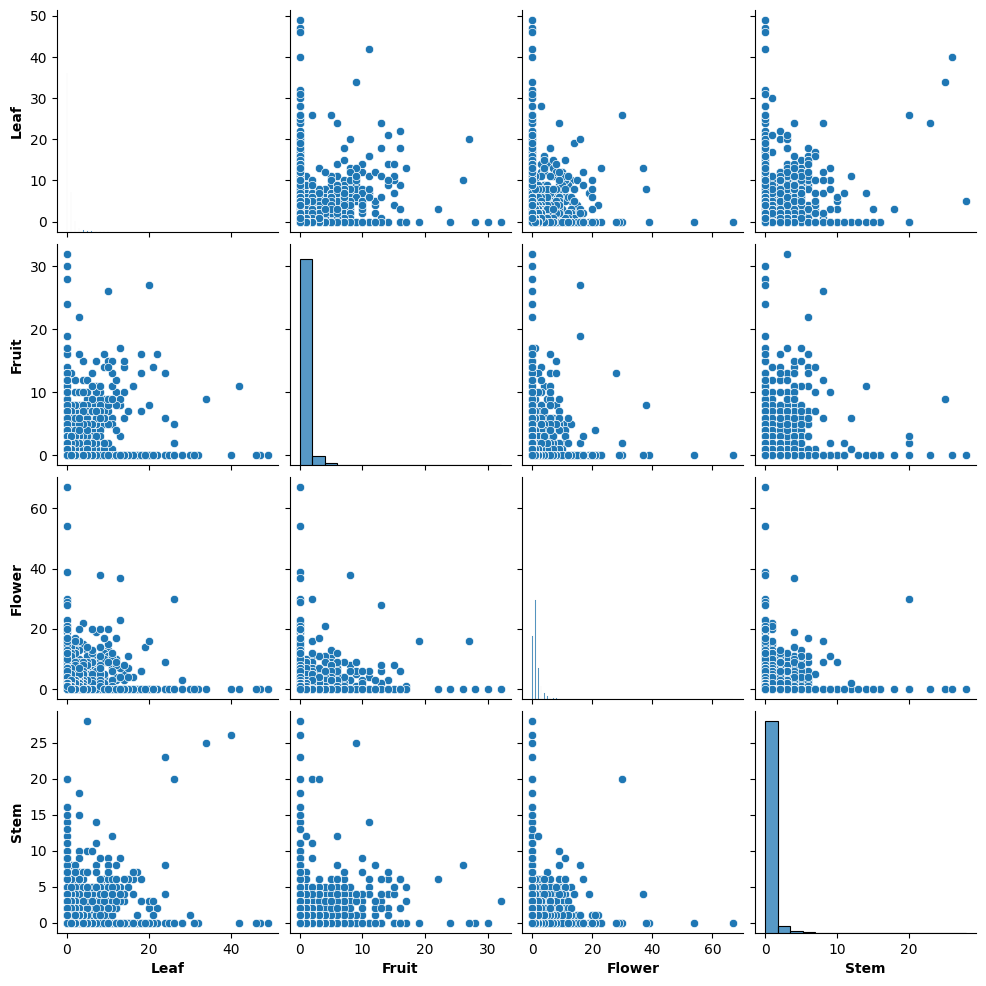

In [14]:
save = False  # <<<<<<< SET TO TRUE TO SAVE PLOT


grid = sns.pairplot(plant_clef_observations.drop(columns=["ObservationId", "ClassId"]))
for ax in grid.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontdict=FONT_LABEL)
    ax.set_ylabel(ax.get_ylabel(), fontdict=FONT_LABEL)

if save:
    save_plot("organs_pair_plot.pdf")

<Axes: >

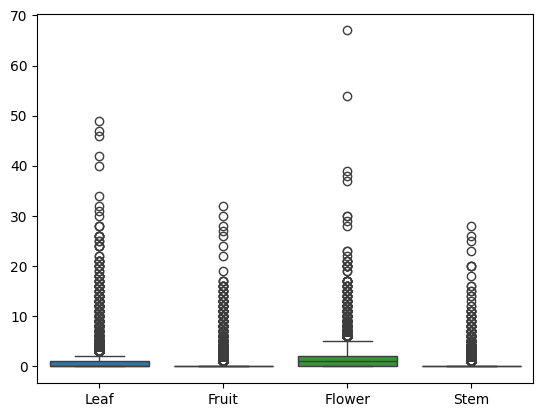

In [15]:
sns.boxplot(plant_clef_observations.drop(columns=["ObservationId", "ClassId"]))

# Plot Organ Distribution among Classes

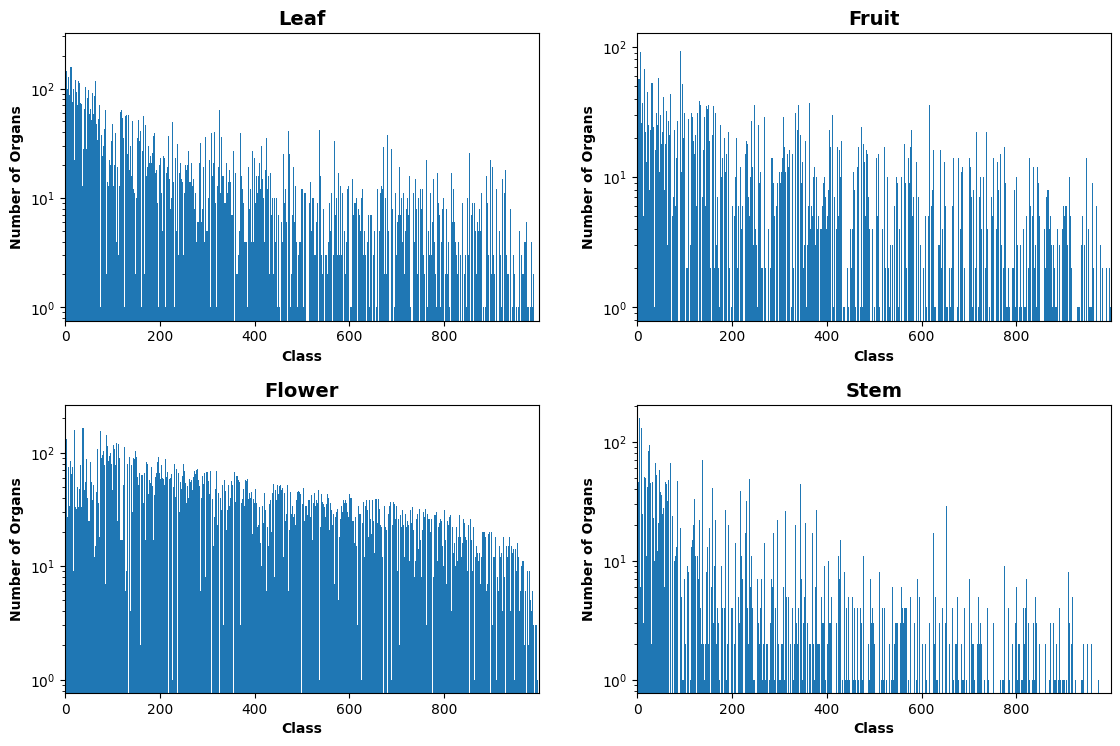

In [16]:
save = False  # <<<<<<< SET TO TRUE TO SAVE PLOT


def get_class_organ_distribution(df_observations: pd.DataFrame, class_map, organ):
    dist = [0 for _ in range(len(class_map))]

    for cls, index in class_map.items():
        n_organs = df_observations[df_observations["ClassId"] == cls][organ].sum()
        dist[index] = n_organs
    
    return dist

def plot_class_organ_distribution():
    fig, ax = plt.subplots(2, 2)

    fig.set_size_inches((12, 8))
    fig.tight_layout(pad=4)

    ax = np.reshape(ax, -1)

    organs = list(RELEVANT_ORGANS)
    organ_dists = [get_class_organ_distribution(plant_clef_observations, plant_clef_class_map, organ) for organ in RELEVANT_ORGANS]

    for index in range(len(organ_dists)):
        dist = organ_dists[index]
        indices = range(len(dist))

        ax[index].set_yscale("log")
        ax[index].set_xlim([-1, len(indices)])
        ax[index].bar(indices, dist, width=1)
        ax[index].set_title(organs[index], fontdict=FONT_TITLE)
        ax[index].set_xlabel("Class", fontdict=FONT_LABEL)
        ax[index].set_ylabel("Number of Organs", fontdict=FONT_LABEL)

plot_class_organ_distribution()

if save:
    save_plot("class_organ_distribution.pdf")